In [41]:
import numpy as np
import matplotlib.pyplot as plt



# Parameters
a = 0.0  # Coefficient for x^3 term
b = 1.0  # Coefficient for x^4 term
beta = 1.0  # Inverse temperature

# Step 1: Load the data and process it as before
all_positions = []
current_block = []

with open('condizioni_iniziali.dat', 'r') as f:  # Replace 'your_file.txt' with your actual filename
    for line in f:
        line = line.strip()
        if line and '-' not in line:  # Ignore separator lines
            position = float(line.split()[0])  # Extract the position (first column)
            current_block.append(position)
        elif current_block:  # If we hit a separator, save the block
            all_positions.append(current_block)
            current_block = []

    if current_block:  # Save the last block if no separator at end
        all_positions.append(current_block)

# Step 2: Calculate differences within each block
position_diffs = []
for block in all_positions:
    if len(block) > 1:
        diffs = np.diff(block)
        position_diffs.extend(diffs)

# Step 3: Plot histogram of position differences
plt.hist(position_diffs, bins=40, density=True, alpha=0.6, edgecolor='black', label='Position Differences')

# Step 4: Define the energy function and density based on Boltzmann distribution
def energy(x, a, b):
    return (x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(position_diffs), max(position_diffs), 500)
density_vals = density(x_vals, a, b, beta)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Position Differences with Energy-based Density')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'condizioni_iniziali.dat'

4001220
(10000, 166)


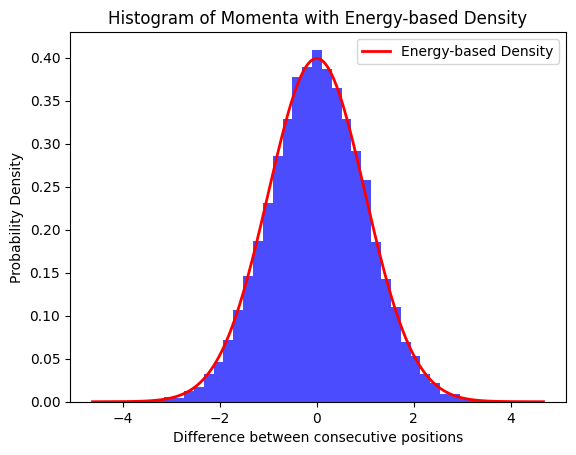

In [32]:
import numpy as np
import os
import random

def read_conditions(filename, num_condizioni, neq):
    # Verifica se il file esiste
    if not os.path.exists(filename):
        print("Errore nell'apertura del file per lettura!")
        return None
    
    # Dimensione di una condizione in byte
    dimensione_condizione = neq * np.dtype('float64').itemsize
    
    # Ottieni la dimensione totale del file
    file_size = os.path.getsize(filename)
    
    # Calcola il numero di condizioni nel file
    numero_condizioni_tot = file_size // dimensione_condizione

    print(numero_condizioni_tot)
    
    if num_condizioni > numero_condizioni_tot:
        print("Errore: il numero di condizioni richiesto eccede il numero di condizioni nel file.")
        return None

    # Inizializza il vettore per le condizioni
    condizioni = np.empty(num_condizioni * neq, dtype='float64')

    # Apri il file in modalità binaria
    with open(filename, 'rb') as inFile:
        for i in range(num_condizioni):
            # Seleziona un indice casuale
            indice_casuale = random.randint(0, numero_condizioni_tot - 1)
            
            # Calcola l'offset dell'indice
            offset = indice_casuale * dimensione_condizione
            
            # Posizionarsi nel file all'offset desiderato
            inFile.seek(offset)
            
            # Leggi la condizione e mettila nel vettore
            condition_data = np.fromfile(inFile, dtype='float64', count=neq)
            if condition_data.size != neq:
                print("Errore durante la lettura del file!")
                return None
            
            condizioni[i * neq : (i + 1) * neq] = condition_data

    return condizioni


filename = "condizioni_80.bin"
num_condizioni = 10000  # Numero di condizioni da leggere
N=80
dim=1
neq= (N+2)*2*dim + 2

condizioni = read_conditions(filename, num_condizioni, neq)
if condizioni is not None:
    cond_t=condizioni.reshape(num_condizioni,neq)[:,:neq]
print(cond_t.shape)


import numpy as np
import matplotlib.pyplot as plt

# Supponendo che `cond_t` sia già definito
# Estrai solo le colonne di `x` per ciascuna catena
x_values = cond_t[:, ::2]  # Prende solo le colonne alternate, che sono i valori `x`
p_values=np.concatenate(cond_t[:, 3:-2:2])
xival=np.concatenate(cond_t[:, -2:])
# Calcola le differenze tra valori successivi di `x` per ciascuna catena (prima dimensione)
diff_x_all = [np.diff(x_chain) for x_chain in x_values]

# Unisci tutte le differenze in un singolo array per l'istogramma
diff_x_all = np.concatenate(diff_x_all)

# Crea l'istogramma delle differenze
plt.hist(xival, bins=40, density=True, alpha=0.7, color='blue')

def energy(x, a, b):
    return x**2/2#(x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(p_values), max(p_values), 500)
density_vals = density(x_vals, 0, 1, 1)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Momenta with Energy-based Density')
plt.legend()
plt.show()

In [5]:
cond_t[0,62:]

array([31.,  0.])

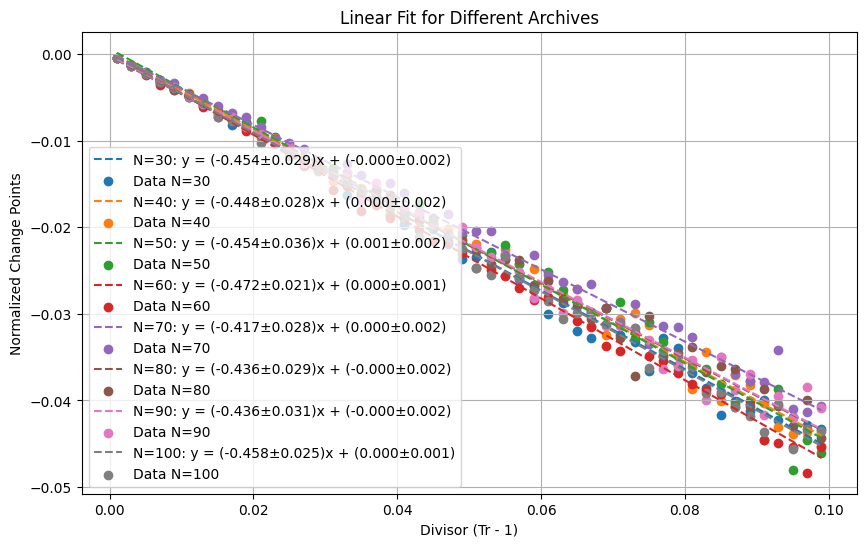

In [16]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tarfile
import re
from skchange.change_detectors.moving_window import MovingWindow
import os

# List of archive paths
archive_paths = [
    "/home/dcarbone/catene/single_data/compressed_archive_N_30.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_40.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_50.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_60.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_70.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_80.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_90.tar.gz",
    "/home/dcarbone/catene/single_data/compressed_archive_N_100.tar.gz",
    # Add more archives if necessary
]

plt.figure(figsize=(10, 6))  # Create a figure for all fits

for archive_path in archive_paths:
    with tarfile.open(archive_path, 'r:gz') as archive:
        # List all .dat files in the archive
        files = [member.name for member in archive.getmembers() if member.name.endswith('.dat')]
        
        lista = []
        lista_t = []
        archive_label = re.search(r'compressed_archive_N_(\d+)', archive_path).group(1)  # Extract particle count

        for file_name in files:
            with archive.extractfile(file_name) as file:
                if "Tr_1.dat" not in file_name:
                    match = re.search(r'Tr_([0-9.]+)', file_name)
                    if match:
                        Tr_str = match.group(1).strip('.')
                        try:
                            Tr = float(Tr_str)
                        except ValueError:
                            print(f"Error: Couldn't convert Tr value '{Tr_str}' to float in filename {file}, skipping...")
                            continue
                    else:
                        print(f"Warning: Couldn't extract Tr from filename {file}, skipping...")
                        continue

                    data = np.loadtxt(file)
                    if data.shape[1] != 2:
                        print(f"Warning: {file} doesn't have exactly two columns, skipping...")
                        continue

                    x = data[:, 0]
                    y = data[:, 1]
                    divisor = Tr - 1
                    x_normalized = x / divisor
                    y_normalized = y / divisor

                    df = pd.DataFrame(x_normalized[:50000])
                    detector = MovingWindow(bandwidth=10000, min_detection_interval=500
                            )
                    predicted_change_points = detector.fit_predict(df)

                    lista.append(y_normalized[predicted_change_points[0]])
                    lista_t.append(divisor)

        # Perform linear regression
        x = np.array(lista_t)
        y = np.array(lista) * np.array(lista_t)
        result = linregress(x, y)
        slope = result.slope
        intercept = result.intercept
        slope_error = result.stderr / np.sqrt(np.sum((x - np.mean(x))**2))
        intercept_error = result.stderr * np.sqrt(1 / len(x) + np.mean(x)**2 / np.sum((x - np.mean(x))**2))

        # Plot the fit
        y_fit = slope * x + intercept
        plt.plot(x, y_fit, label=f'N={archive_label}: y = ({slope:.3f}±{slope_error:.3f})x + ({intercept:.3f}±{intercept_error:.3f})', linestyle='--')
        plt.scatter(x, y, label=f'Data N={archive_label}')

# Finalize the plot
plt.xlabel("Divisor (Tr - 1)")
plt.ylabel("Normalized Change Points")
plt.title("Linear Fit for Different Archives")
plt.legend()
plt.grid()
plt.show()


Slope: -0.4359 ± 0.0060
Intercept: -0.0003 ± 0.0003


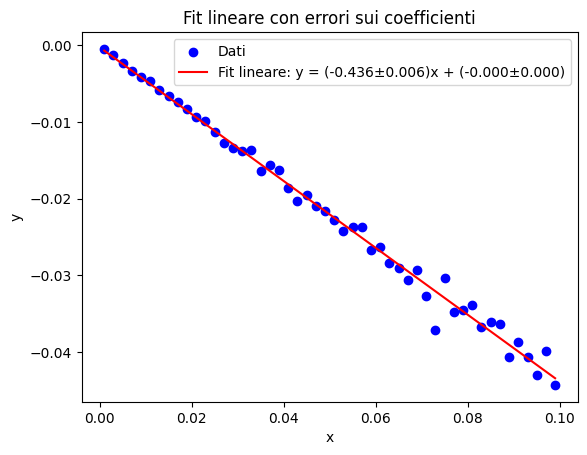

In [43]:
0.44*np.sqrt(8/3)

0.7185169912163989

<Axes: >

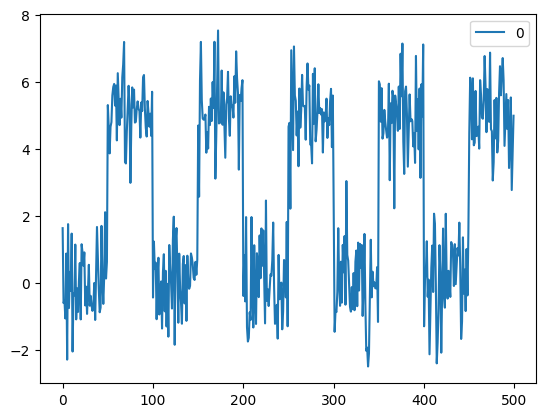

In [2]:
df.plot()